In [137]:
import numpy as np
import matplotlib.pyplot as plt
import copy


Initialize the parameters as per required dimesions:

In [138]:

def initialize_parameters_deep(layer_dims):

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
       
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

        
      
    return parameters


Implement the forward propagation of the *LINEAR->ACTIVATION* layer. Mathematical relation is: $A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ where the activation "g" can be sigmoid() or relu(). Use `linear_forward()` and the correct activation function.

In [139]:

def linear_activation_forward(A_prev, W, b, activation):
  
    
    if activation == "sigmoid":
        Z=np.dot(W,A_prev)+b
        A=1/(1+np.exp(-Z))
       
    elif activation == "relu":
       
        Z=np.dot(W,A_prev)+b
        A=np.maximum(0,Z)

    linear_cache = (A_prev, W, b)
    activation_cache = Z
        
    cache = (linear_cache, activation_cache)

    return A, cache


- Use the functions  previously written 
- Use a for loop to replicate [LINEAR->RELU] (L-1) times
- Don't forget to keep track of the caches in the "caches" list. To add a new value `c` to a `list`, you can use `list.append(c)`.

In [140]:

def L_model_forward(X, parameters):
  
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
   
    for l in range(1, L):
        A_prev = A 
        W = parameters["W" + str(l)]
        b = parameters["b" + str(l)]
        A, cache = linear_activation_forward(A_prev, W, b, activation="relu")
        caches.append(cache)
       
    W = parameters["W" + str(L)]
    b = parameters["b" + str(L)]
    AL, cache = linear_activation_forward(A, W, b, activation="sigmoid")
    caches.append(cache)
    
  
          
    return AL, caches

![Screenshot 2024-06-28 115022.png](<attachment:Screenshot 2024-06-28 115022.png>)
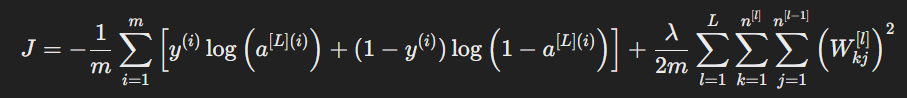

In [141]:


def compute_cost(AL, Y,lambd,parameters):
   
    m = Y.shape[1]
    L=len(parameters)//2

    cost=-(1/m)*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))
    
   

    ragularization_cost=0
    for i in range(L):
        ragularization_cost+=np.sum(np.square(parameters["W"+str(i+1)]))
      
    ragularization_cost=(lambd/(2*m))*ragularization_cost
    cost=cost+ragularization_cost
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).

    
    return cost

In [142]:

def linear_activation_backward(dA, cache,lambd, activation):
   
    linear_cache, activation_cache = cache
    A_prev,w,b=linear_cache
    z=activation_cache
    m=dA.shape[1]
    if activation == "relu":
        dz=dA*(z>0)
        dA_prev=np.dot(w.T,dz)
        
 
        
    elif activation == "sigmoid":
        dz=dA*((1/(1+np.exp(-z)))*(1-1/(1+np.exp(-z))))
        
      
        
    dA_prev=np.dot(w.T,dz)
    dW=(1/z.shape[1])*np.dot(dz,A_prev.T)+(lambd/m)*(w)
    db=(1/z.shape[1])*np.sum(dz,axis=1,keepdims=True)    
    
    return dA_prev, dW, db



**Initializing backpropagation**:

To backpropagate through this network, you know that the output is: 
$A^{[L]} = \sigma(Z^{[L]})$.Needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

You can then use this post-activation gradient `dAL` to keep going backward. 

After that, you will have to use a `for` loop to iterate through all the other layers using the LINEAR->RELU backward function. Now, store each dA, dW, and db in the grads dictionary. To do so, use this formula : 

$$grads["dW" + str(l)] = dW^{[l]}\tag{15} $$





In [143]:

def L_model_backward(AL, Y, caches,lambd):
  
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
  
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]

    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache,lambd, activation="sigmoid")

    
    
 
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache,lambd, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads



$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate. 



In [144]:

def update_parameters(params, grads, learning_rate):
   
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    
    for l in range(L):
        parameters["W" + str(l+1)] -=learning_rate*grads['dW'+str(l+1)] 
        parameters["b" + str(l+1)] -=learning_rate*grads['db'+str(l+1)] 
       
    return parameters

In [145]:

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False,lambd=.7):
   

    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
   
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X,parameters)
       
        # Compute cost.
        cost = compute_cost(AL,Y,lambd,parameters)
        cost=np.array(cost)
        
        # Backward propagation.
        grads =L_model_backward(AL,Y,caches,lambd)
      
 
        # Update parameters.
        parameters =update_parameters(parameters, grads, learning_rate)
        
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
          
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [ ]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2000, print_cost = True,learning_rate=.005,lambd=.3)